### Week 6 HW - What's the Weather Like? using APIs and JSON
#### by: Michael Suomi  6/23/2018
- Observation 1: Temperature does tend to get cooler when you move farther away from the equator - you notice  higher relative temperatures in northern latitudes relative to the southern latitudes because it is currently summer in northern hemisphere and winter in summer hemisphere.
- Observation 2: There are not any real discernable trends for Humidity Cloudiness or Wind Speed as you move away from the equator (although there is a slight uptick in wind speed around the -40 to -50 latitudes).
- Observation 3: CiityPy stores many more cities in Europe than any other locations around the world - when I first randomly chose from their dictionary of cities and create a google maps plot they were most dense in Europe.

#### WeatherPy Instructions:

In this example, you'll be creating a Python script to visualize the weather of 500+ cities across the world of varying distance from the equator. To accomplish this, you'll be utilizing a simple Python library, the OpenWeatherMap API, and a little common sense to create a representative model of weather across world cities.

Your objective is to build a series of scatter plots to showcase the following relationships:


- Temperature (F) vs. Latitude
- Humidity (%) vs. Latitude
- Cloudiness (%) vs. Latitude
- Wind Speed (mph) vs. Latitude


Your final notebook must:


- Randomly select at least 500 unique (non-repeat) cities based on latitude and longitude.
- Perform a weather check on each of the cities using a series of successive API calls.
- Include a print log of each city as it's being processed with the city number and city name.
- Save both a CSV of all data retrieved and png images for each scatter plot.

In [1]:
import os
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from citipy import citipy
import random
import gmaps
gmaps.configure(api_key=os.environ.get('googlemaps_api_key'))
openweathermap_api_key = os.environ.get('openweathermap_api_key')
data_output_folder = "data_output\\"

#### Randomly select 500 unique cities based on latitude and longitude. 

In [2]:
###in order to get better city distribution, make latitude bands of 5 degrees and then 
###choose 20 random cities from each of those latitude bands
random_lat_longs3 = []

for lat_search in list(range(-90,90,5)):
    lat_range_cities = [x for x in list(citipy.WORLD_CITIES_DICT.keys())
                        if (lat_search+5) > x[0] and lat_search >= x[0]]
    
    #determine number of random cities to get out of the range:
    #if number of cities is less than 20 then just select all cities
    #otherwise select 20 random cities and add to city list
    if len(lat_range_cities) > 20:
        num_random_cities = 20
        for num_cities in list(range(num_random_cities)):
            random_lat_longs3.append(random.choice(lat_range_cities))
    else:
        for city in lat_range_cities:
            random_lat_longs3.append(city)
            
random_city_citipy_encodings3 = [citipy.WORLD_CITIES_DICT[x] for x in random_lat_longs3]
random_city_names3 = [x.city_name for x in random_city_citipy_encodings3]
random_countries3 = [x.country_code for x in random_city_citipy_encodings3]

In [3]:
#create dataframe of the random cities
df_random_cities3 = pd.DataFrame({'City': random_city_names3,
                                 'Country': random_countries3,
                                 'Lat, Long': random_lat_longs3, 
                                 'Lat': [x[0] for x in random_lat_longs3],
                                 'Lon': [x[1] for x in random_lat_longs3]})
df_random_cities3 = df_random_cities3[['City', 'Country', 'Lat, Long', 'Lat', 'Lon']]

#due to random chance there may be duplicate cities (especially if the number of
#cities in the lat, long range is short) so drop the duplicate cities
df_random_cities3.drop_duplicates(inplace=True)
#google maps errors out when reference the data frame columns if the index is not sequential, so reset index
df_random_cities3.reset_index(drop=True, inplace=True)
print(df_random_cities3.shape)
df_random_cities3.head()

(517, 5)


,City,Country,"Lat, Long",Lat,Lon
0,rio gallegos,ar,"(-51.622613, -69.218127)",-51.622613,-69.218127
1,ushuaia,ar,"(-54.8, -68.3)",-54.800000,-68.300000
2,punta arenas,cl,"(-53.15, -70.916667)",-53.150000,-70.916667
3,riverton,nz,"(-46.35, 168.016667)",-46.350000,168.016667
4,wyndham,nz,"(-46.333333, 168.85)",-46.333333,168.850000


In [4]:
#create a google map of the locations to see how spread out the random cities really are and to 
#make sure it really covers various lat,longs
fig3 = gmaps.figure()

markers = gmaps.marker_layer(locations=df_random_cities3['Lat, Long'], 
                             info_box_content=df_random_cities3['Country']) #click will give country code

fig3.add_layer(markers)
fig3

Figure(layout=FigureLayout(height='420px'))

#### Calling 5-Day Forecast Weather API

In [5]:
#create a new dataframe and then overwrite the values
df_random_cities_forecast3 = df_random_cities3
# #if need to overwrite dataframe values when re-run df
# df_random_cities_forecast3[['OWM City #', 'OWM City Name', 'Temp (F)', 'Humidity (%)',
#                           'Cloudiness (%)', 'Wind Speed (mph)']] = ''

In [6]:
## in order to get better picture of the weather data than just the exact moment we pull it, 
## use the 5 day forecast API (we can't use the historical data without paying for an account)
print('Beginning Data Retrieval \n-------------------------------')

for index, city_row in df_random_cities_forecast3.iterrows():
    print(f"Processing Record {index+1} of {len(df_random_cities_forecast3)}")
    #api.openweathermap.org/data/2.5/forecast?lat=35&lon=139
    #http://samples.openweathermap.org/data/2.5/forecast?lat=35&lon=139&appid=b6907d289e10d714a6e88b30761fae22

    base_url = 'http://api.openweathermap.org/data/2.5/forecast?'
    parameters = {'lat': city_row['Lat'], 
                 'lon': city_row['Lon'], 
                 'appid': openweathermap_api_key, 
                 'units': 'imperial'}
    
    #print url looking at, but hide the api key by replacing with #'s
    print((requests.get(base_url, parameters).url).replace(openweathermap_api_key, '#'*len(openweathermap_api_key)))
    #get json
    city_weather_data = requests.get(base_url, parameters).json()
    #print(city_weather_data) #temporary check
   
    ###for some reason city_row['column'] = did not work because its a copy of slice,
    ### so use .loc on dataframe instead
    ###get the city id and city name for the processing print records and save into dataframe
    df_random_cities_forecast3.loc[index, 'OWM City #'] = city_weather_data.get('city').get('id')
    df_random_cities_forecast3.loc[index, 'OWM City Name'] = city_weather_data.get('city').get('name')
    print(f"City ID = {city_weather_data.get('city').get('id')}, City Name = {city_weather_data.get('city').get('name')}")
    
    ###for all the forecast data, create a list that collects the weather values and
    ###then takes max temp of the forecasts, and takes the mean of the other forecasts
    df_random_cities_forecast3.loc[index, 'Temp (F)'] = max(
                [x.get('main').get('temp') for x in city_weather_data.get('list')])
    df_random_cities_forecast3.loc[index, 'Humidity (%)'] = np.mean(
                [x.get('main').get('humidity') for x in city_weather_data.get('list')])
    df_random_cities_forecast3.loc[index, 'Cloudiness (%)'] = np.mean(
                [x.get('clouds').get('all') for x in city_weather_data.get('list')])
    df_random_cities_forecast3.loc[index, 'Wind Speed (mph)'] = np.mean(
                [x.get('wind').get('speed') for x in city_weather_data.get('list')])

print('-------------------------------\n Data Retrieval Complete \n-------------------------------')

Beginning Data Retrieval 
-------------------------------
Processing Record 1 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-51.622613&lon=-69.218127&appid=################################&units=imperial
City ID = 3838859, City Name = Rio Gallegos
Processing Record 2 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-54.8&lon=-68.3&appid=################################&units=imperial
City ID = 3833367, City Name = Ushuaia
Processing Record 3 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-53.15&lon=-70.916667&appid=################################&units=imperial
City ID = 3874787, City Name = Punta Arenas
Processing Record 4 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-46.35&lon=168.016667&appid=################################&units=imperial
City ID = 2206957, City Name = Riverton
Processing Record 5 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-46.333333&lon=168.85&appid=################################&units=imperial
Ci

http://api.openweathermap.org/data/2.5/forecast?lat=-39.366667&lon=-72.633333&appid=################################&units=imperial
City ID = 3882582, City Name = Loncoche
Processing Record 43 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-41.438759&lon=147.134674&appid=################################&units=imperial
City ID = 2155392, City Name = Newstead
Processing Record 44 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-37.56266&lon=143.862579&appid=################################&units=imperial
City ID = 8014922, City Name = Ballarat Central
Processing Record 45 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-35.1&lon=173.783333&appid=################################&units=imperial
City ID = 2189343, City Name = Kaeo
Processing Record 46 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-36.892715&lon=-60.32254&appid=################################&units=imperial
City ID = 3842670, City Name = Olavarria
Processing Record 47 of 517
ht

http://api.openweathermap.org/data/2.5/forecast?lat=-33.295012&lon=-66.335627&appid=################################&units=imperial
City ID = 3837056, City Name = San Luis
Processing Record 84 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-26.933655&lon=29.241518&appid=################################&units=imperial
City ID = 952747, City Name = Standerton
Processing Record 85 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-25.4314&lon=-48.7184&appid=################################&units=imperial
City ID = 3472048, City Name = Antonina
Processing Record 86 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-29.85&lon=-51.166667&appid=################################&units=imperial
City ID = 3463859, City Name = Esteio
Processing Record 87 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-30.302249&lon=27.083951&appid=################################&units=imperial
City ID = 937246, City Name = Zastron
Processing Record 88 of 517
http://api.op

http://api.openweathermap.org/data/2.5/forecast?lat=-23.216667&lon=-44.716667&appid=################################&units=imperial
City ID = 3455036, City Name = Parati
Processing Record 126 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-33.593333&lon=-71.621667&appid=################################&units=imperial
City ID = 3872395, City Name = San Antonio
Processing Record 127 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-20.225&lon=57.5872222&appid=################################&units=imperial
City ID = 1106782, City Name = Espérance
Processing Record 128 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-22.016667&lon=-47.9&appid=################################&units=imperial
City ID = 3449319, City Name = Sao Carlos
Processing Record 129 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-23.116667&lon=-48.6&appid=################################&units=imperial
City ID = 3460594, City Name = Itatinga
Processing Record 130 of 517
http

http://api.openweathermap.org/data/2.5/forecast?lat=-12.366667&lon=-40.666667&appid=################################&units=imperial
City ID = 3446587, City Name = Terra Nova
Processing Record 167 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-34.8&lon=-54.9166667&appid=################################&units=imperial
City ID = 3440696, City Name = San Carlos
Processing Record 168 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-4.2&lon=36.9333333&appid=################################&units=imperial
City ID = 152042, City Name = Naberera
Processing Record 169 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-18.5333333&lon=32.1166667&appid=################################&units=imperial
City ID = 882100, City Name = Rusape
Processing Record 170 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-4.333333&lon=-38.883333&appid=################################&units=imperial
City ID = 3405954, City Name = Baturite
Processing Record 171 of 517
http:

http://api.openweathermap.org/data/2.5/forecast?lat=4.8833333&lon=-1.75&appid=################################&units=imperial
City ID = 2294915, City Name = Takoradi
Processing Record 208 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-17.75&lon=-48.633333&appid=################################&units=imperial
City ID = 3468100, City Name = Caldas Novas
Processing Record 209 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-5.783333&lon=-43.25&appid=################################&units=imperial
City ID = 3400617, City Name = Estreito
Processing Record 210 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-2.55&lon=36.7833333&appid=################################&units=imperial
City ID = 184570, City Name = Namanga
Processing Record 211 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=4.898056&lon=-74.436944&appid=################################&units=imperial
City ID = 3684270, City Name = El Dorán
Processing Record 212 of 517
http://api.open

http://api.openweathermap.org/data/2.5/forecast?lat=10.9733&lon=124.5351&appid=################################&units=imperial
City ID = 1692691, City Name = Puerto Bello
Processing Record 250 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=12.229056&lon=121.228112&appid=################################&units=imperial
City ID = 1731502, City Name = Alibug
Processing Record 251 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=3.5679&lon=98.956&appid=################################&units=imperial
City ID = 1214191, City Name = Perbaungan
Processing Record 252 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=19.9&lon=83.166667&appid=################################&units=imperial
City ID = 1276023, City Name = Bhawanipatna
Processing Record 253 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-6.741389&lon=107.019167&appid=################################&units=imperial
City ID = 1647298, City Name = Caringin
Processing Record 254 of 517
http://ap

City ID = 1690056, City Name = San Fernando
Processing Record 291 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-6.51&lon=-79.8583333&appid=################################&units=imperial
City ID = 3691161, City Name = Tucume
Processing Record 292 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=9.5994&lon=118.3489&appid=################################&units=imperial
City ID = 1730290, City Name = Apurawan
Processing Record 293 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=24.9&lon=-76.2&appid=################################&units=imperial
City ID = 3571592, City Name = Rock Sound
Processing Record 294 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=14.905978&lon=105.078364&appid=################################&units=imperial
City ID = 1610940, City Name = Det Udom
Processing Record 295 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-26.6480556&lon=15.1594444&appid=################################&units=imperial
City ID = 33

http://api.openweathermap.org/data/2.5/forecast?lat=16.516667&lon=-92.733333&appid=################################&units=imperial
City ID = 3531010, City Name = Chiapilla
Processing Record 333 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=8.6666667&lon=14.1833333&appid=################################&units=imperial
City ID = 2222439, City Name = Rey Bouba
Processing Record 334 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=10.5&lon=-66.85&appid=################################&units=imperial
City ID = 3645981, City Name = Chacao
Processing Record 335 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=16.3833333&lon=95.2666667&appid=################################&units=imperial
City ID = 1308464, City Name = Mawlamyinegyunn
Processing Record 336 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=19.483333&lon=79.6&appid=################################&units=imperial
City ID = 1256063, City Name = Sirpur
Processing Record 337 of 517
http://ap

http://api.openweathermap.org/data/2.5/forecast?lat=46.80165&lon=17.220957&appid=################################&units=imperial
City ID = 3054164, City Name = Cserszegtomaj
Processing Record 375 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=45.698333&lon=21.635833&appid=################################&units=imperial
City ID = 669320, City Name = Racovita
Processing Record 376 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=45.35&lon=-72.516667&appid=################################&units=imperial
City ID = 6176821, City Name = Waterloo
Processing Record 377 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=46.9&lon=23.566667&appid=################################&units=imperial
City ID = 667006, City Name = Sanmartin
Processing Record 378 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-1.9166667&lon=175.5833333&appid=################################&units=imperial
City ID = 2110204, City Name = Eriko Village
Processing Record 379 of 517
ht

http://api.openweathermap.org/data/2.5/forecast?lat=11.583333&lon=77.916667&appid=################################&units=imperial
City ID = 1266189, City Name = Konganapuram
Processing Record 417 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=54.2167&lon=57.5556&appid=################################&units=imperial
City ID = 556279, City Name = Inzer
Processing Record 418 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=52.266667&lon=-113.8&appid=################################&units=imperial
City ID = 6118158, City Name = Red Deer
Processing Record 419 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=9.528056&lon=125.485556&appid=################################&units=imperial
City ID = 1690017, City Name = San Francisco
Processing Record 420 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=59.1325&lon=24.3711111&appid=################################&units=imperial
City ID = 592168, City Name = Harku
Processing Record 421 of 517
http://api.o

http://api.openweathermap.org/data/2.5/forecast?lat=45.116667&lon=28.366667&appid=################################&units=imperial
City ID = 676343, City Name = Hamcearca
Processing Record 459 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=47.533333&lon=27.283333&appid=################################&units=imperial
City ID = 686341, City Name = Andrieseni
Processing Record 460 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=-21.75&lon=-41.3&appid=################################&units=imperial
City ID = 3467693, City Name = Campos
Processing Record 461 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=11.544444&lon=-72.907222&appid=################################&units=imperial
City ID = 3670745, City Name = Riohacha
Processing Record 462 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=58.0666667&lon=27.0452778&appid=################################&units=imperial
City ID = 589375, City Name = Polva
Processing Record 463 of 517
http://api.ope

http://api.openweathermap.org/data/2.5/forecast?lat=43.264057&lon=-1.978942&appid=################################&units=imperial
City ID = 3120811, City Name = Hernani
Processing Record 501 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=45.553333&lon=12.071944&appid=################################&units=imperial
City ID = 3172252, City Name = Noale
Processing Record 502 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=61.5&lon=23.75&appid=################################&units=imperial
City ID = 634964, City Name = Tampere
Processing Record 503 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=47.05&lon=25.516667&appid=################################&units=imperial
City ID = 684870, City Name = Bilbor
Processing Record 504 of 517
http://api.openweathermap.org/data/2.5/forecast?lat=24.0666667&lon=90.9666667&appid=################################&units=imperial
City ID = 1185263, City Name = Bhairab Bazar
Processing Record 505 of 517
http://api.openweath

In [7]:
df_random_cities_forecast3.to_csv(f"{data_output_folder}Random City Weather Data.csv")
df_random_cities_forecast3.head()

,City,Country,"Lat, Long",Lat,Lon,OWM City #,OWM City Name,Temp (F),Humidity (%),Cloudiness (%),Wind Speed (mph)
0,rio gallegos,ar,"(-51.622613, -69.218127)",-51.622613,-69.218127,3838859.0,Rio Gallegos,41.56,96.025,46.7,15.9875
1,ushuaia,ar,"(-54.8, -68.3)",-54.800000,-68.300000,3833367.0,Ushuaia,36.34,99.800,62.4,5.4565
2,punta arenas,cl,"(-53.15, -70.916667)",-53.150000,-70.916667,3874787.0,Punta Arenas,42.58,99.850,39.4,15.4440
3,riverton,nz,"(-46.35, 168.016667)",-46.350000,168.016667,2206957.0,Riverton,47.66,92.325,75.9,13.1475
4,wyndham,nz,"(-46.333333, 168.85)",-46.333333,168.850000,2178933.0,Wyndham,46.58,90.575,79.5,12.8385


#### Plotting Weather Results

In [8]:
#y_data is the df_random_cities['column'] and x_data is df_random_cities['column'] for x_axis
#y_label is the name you want for y and x_label for x - labels default to name of df series
def scatter_plot(x_data, y_data, x_label=None, y_label=None):
    if x_label==None:
        x_label=x_data.name  
    if y_label==None:
        y_label=y_data.name
            
    plt.figure(figsize=(10,6), )

    plt.scatter(x_data, y_data)

    plt.xlim(-90,90)
#   plt.ylim(0)

    plt.xlabel(x_label, size=12, fontweight='semibold')
    plt.ylabel(y_label, size=12, fontweight='semibold')
    plt.grid(linestyle='--')
    
    plt.title(f'{y_label} vs. {x_label}', size=14, fontweight='bold')
    plt.savefig(f"{data_output_folder}{y_label} vs. {x_label}.png")
    plt.show()

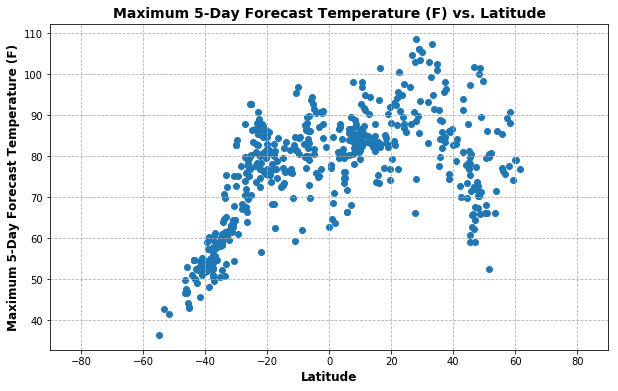

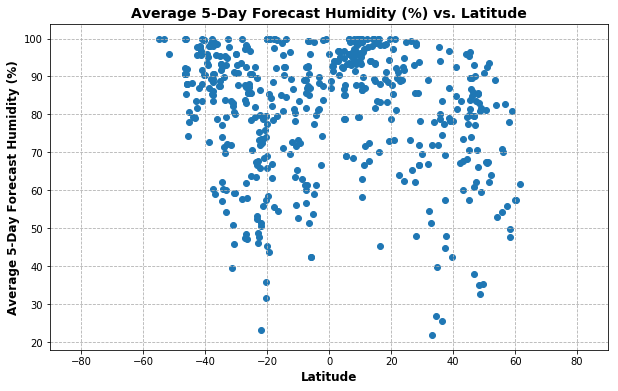

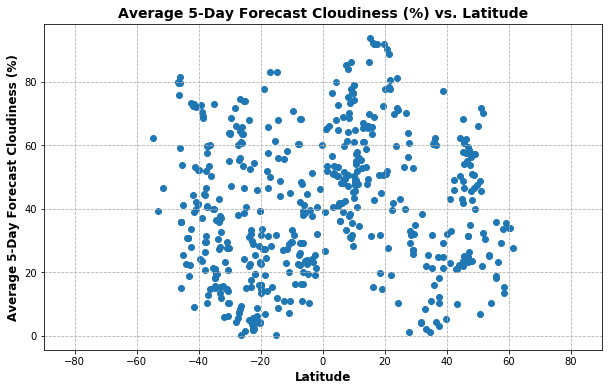

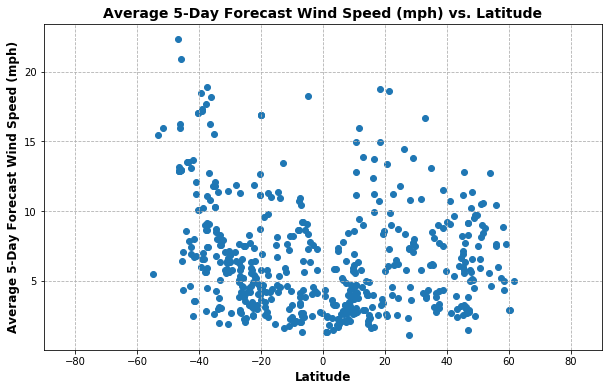

In [9]:
scatter_plot(df_random_cities_forecast3['Lat'], df_random_cities_forecast3['Temp (F)'],
             'Latitude', 'Maximum 5-Day Forecast Temperature (F)')
scatter_plot(df_random_cities_forecast3['Lat'], df_random_cities_forecast3['Humidity (%)'],
             'Latitude', 'Average 5-Day Forecast Humidity (%)')
scatter_plot(df_random_cities_forecast3['Lat'], df_random_cities_forecast3['Cloudiness (%)'],
             'Latitude', 'Average 5-Day Forecast Cloudiness (%)')
scatter_plot(df_random_cities_forecast3['Lat'], df_random_cities_forecast3['Wind Speed (mph)'],
             'Latitude', 'Average 5-Day Forecast Wind Speed (mph)')